In [ ]:
%tensorflow_version 2.8.0
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.autograph.set_verbosity(0)

import keras
keras.__version__

!pip install numpy
import numpy as np

import random
seed = 32
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# MSIS579 Lab4: Recurrent Neural Networks to Movie Review Sentiment Analysis

Another popular and powerful way to associate a vector with a word is the use of dense "word vectors", also called "word embeddings". 
While the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros) and very high-dimensional (same dimensionality as the 
number of words in the vocabulary), "word embeddings" are low-dimensional floating point vectors 
(i.e. "dense" vectors, as opposed to sparse vectors). 
Unlike word vectors obtained via one-hot encoding, word embeddings are learned from data. 
It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with very large vocabularies. 
On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or higher (capturing a vocabulary of 20,000 
token in this case). So, word embeddings pack more information into far fewer dimensions. 

<img src="https://s3.amazonaws.com/book.keras.io/img/ch6/word_embeddings.png" alt="word embeddings vs. one hot encoding" width="400"/>


We can learn the word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.

## Learning word embeddings with the `Embedding` layer


The simplest way to associate a dense vector to a word would be to pick the vector at random. The problem with this approach is that the 
resulting embedding space would have no structure: for instance, the words "accurate" and "exact" may end up with completely different 
embeddings, even though they are interchangeable in most sentences. It would be very difficult for a deep neural network to make sense of 
such a noisy, unstructured embedding space. 

To get a bit more abstract: the geometric relationships between word vectors should reflect the semantic relationships between these words. 
Word embeddings are meant to map human language into a geometric space. For instance, in a reasonable embedding space, we would expect 
synonyms to be embedded into similar word vectors, and in general we would expect the geometric distance (e.g. L2 distance) between any two 
word vectors to relate to the semantic distance of the associated words (words meaning very different things would be embedded to points 
far away from each other, while related words would be closer). Even beyond mere distance, we may want specific __directions__ in the 
embedding space to be meaningful. 

It is possible to take a learned embedding for a given language as the starting point, which relies on their transfer learning ability. Most of such embeddings are learned by pre-training of large language model, such as Bert, Roberta, or others. However, it is still necessary to further fine-tune those embeddings with a given task as embeddings depend on task as well. For example, the perfect word embedding space for an 
English-language movie review sentiment analysis model may look very different from the perfect embedding space for an English-language 
legal document classification model. 

For this lab, we are still going to still __learn__ a new embedding space with every new task. Thankfully, backpropagation makes this really easy, and Keras makes it 
even easier. It's just about learning the weights of a layer: the `Embedding` layer.

In [ ]:
from keras.layers import Embedding

embedding_size = 32
# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 32.
embedding_layer = Embedding(10000, embedding_size) # 10000 vocabs


The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes 
as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.


The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of 
integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have 
shapes `(32, 10)` (batch of 32 sequences of length 10). All sequences in a batch must 
have the same length (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded 
with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then 
be processed by a RNN layer.

When you instantiate an `Embedding` layer, its weights (its internal dictionary of token vectors) are randomly initialized, just like with any 
other layer. During training, these embedding vectors will be gradually learned via backpropagation, structuring the space into something that the 
downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for 
the specific problem you were training your model for.

Let's apply this idea to the IMDB movie review sentiment prediction task that you are already familiar with. Let's quickly prepare 
the data. We will restrict the movie reviews to the top 10,000 most common words (like we did the first time we worked with this dataset), 
and cut the reviews after 200 words. Our network will simply learn 32-dimensional embeddings for each of the 10,000 words, turn the 
input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single `Dense` 
layer on top for classification.

In [ ]:
from keras.datasets import imdb
from tensorflow.keras import preprocessing

num_words = 10000
# Cut texts after this number of words 
maxlen = 50

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print(f"input_test ids: {x_test[0]}")

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
print('Pad sequences (samples x time)')
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
print('input_train shape:', x_train.shape)
print('input_test shape:', x_test.shape)

17464789/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
input_test ids: [1, 591, 202, 14, 31, 6, 717, 10, 10, 2, 2, 5, 4, 360, 7, 4, 177, 5760, 394, 354, 4, 123, 9, 1035, 1035, 1035, 10, 10, 13, 92, 124, 89, 488, 7944, 100, 28, 1668, 14, 31, 23, 27, 7479, 29, 220, 468, 8, 124, 14, 286, 170, 8, 157, 46, 5, 27, 239, 16, 179, 2, 38, 32, 25, 7944, 451, 202, 14, 6, 717]
Pad sequences (samples x time)
input_train shape: (25000, 50)
input_test shape: (25000, 50)


First three word index are reserved for special tokens <PAD>, <START>, and <UNK>. So we would need to offset the word index by 3.

In [ ]:
# Convert encoded review to words
INDEX_FROM=3   # word index offset

word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id['<PAD>'] = 0
word_to_id['<START>'] = 1
word_to_id['<UNK>'] = 2 # unkown words
id_to_word = {value:key for key,value in word_to_id.items()}

def decode_from_id(example):
  return(' '.join(id_to_word[id] for id in example ))

print(decode_from_id(x_train[1]))
print(y_train[1])

1641221/1641221 [==============================] - 0s 0us/step
boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then
0


In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()

# TODO: add embedding layer
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(num_words, embedding_size, input_length=maxlen))


# TODO: add flatten layer
# After the Embedding layer, our activations have shape `(samples, maxlen, 32)`.
# We flatten the 3D tensor of embeddings into a 2D tensor of shape `(samples, maxlen * 32)`
model.add(Flatten())

# TODO: add another dense layer with 128 hidden units
model.add(Dense(128, activation='relu'))

# TODO: add the final sigmoid layer to output the binary prediction
# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))

# TODO: compile the model and output the model summary
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()


# TODO: start training the model
history = model.fit(
    x_train,
    y_train,
    epochs=4,
    batch_size=32,
    validation_split=0.2

)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 32)            320000    
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               204928    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 525,057
Trainable params: 525,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
625/625 [==============================] - 22s 28ms/step - loss: 0.5137 - acc: 0.7347 - val_loss: 0.4272 - val_acc: 0.8042
Epoch 2/4
625/625 [============================

In [ ]:
# TODO Evaluate model performance
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.7862 - acc: 0.7708


[0.7862396836280823, 0.770799994468689]

We get to a validation accuracy of ~76%, which is pretty good considering that we only use one embedding layer. But 
note that merely flattening the embedded sequences and training a single `Dense` layer on top leads to a model that treats each word in the 
input sequence separately, without considering inter-word relationships and structure sentence (e.g. it would likely treat both _"this movie 
is shit"_ and _"this movie is the shit"_ as being negative "reviews"). It would be much better to add recurrent layers or 1D convolutional 
layers on top of the embedded sequences to learn features that take into account each sequence as a whole. That's what we will focus on in 
the next few sections.

## Recurrent Neural Networks



In Keras, RNN can be invoked by the API [`SimpleRNN`](https://keras.io/api/layers/recurrent_layers/simple_rnn/), which takes inputs of shape `(batch_size, timesteps, input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument.

Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, Dropout

# TODO: train a simple recurrent network using an Embedding layer and a SimpleRNN layer
model = Sequential()
model.add(Embedding(num_words, embedding_size, input_length=maxlen))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(
    x_train,
    y_train,
    epochs=4,
    batch_size=32,
    validation_split=0.2

)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 32)            320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
625/625 [==============================] - 39s 59ms/step - loss: 0.5200 - acc: 0.7329 - val_loss: 0.4614 - val_acc: 0.7832
Epoch 2/4
625/625 [==============================] - 27s 44ms/step - loss: 0.3651 - acc: 0.8406 - val_loss: 0.4358 - val_acc: 0.7982
Epoch 3/4
625/625 [===========================

In [ ]:
# TODO: evaluate model performance
model.evaluate(x_test, y_test)

782/782 [==============================] - 5s 6ms/step - loss: 0.4724 - acc: 0.8018


[0.472364604473114, 0.8018400073051453]

Let's display the training and validation loss and accuracy:

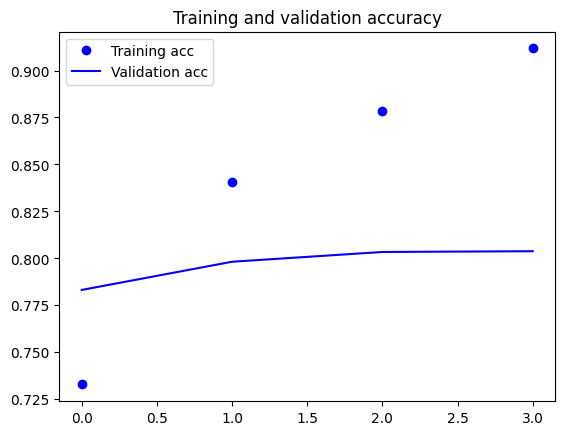

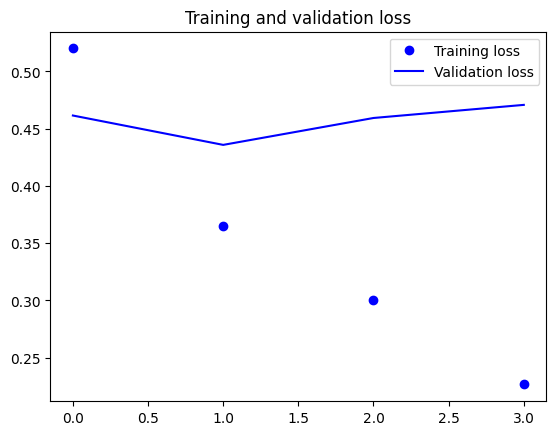

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Our small recurrent network does better than the 1-layer NN with a 79% validation accuracy. Part of the problem is that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.

## Long short-term memory (LSTM)

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning.

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you having to spend time tuning parameters by hand.

Default weight initialization is Xavier uniform initialized. More inforamtion from [here](https://keras.rstudio.com/reference/initializer_glorot_uniform.html)

In [ ]:
from keras.layers import LSTM, Dropout

model = Sequential()
model.add(Embedding(num_words, embedding_size, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(
    x_train,
    y_train,
    epochs=4,
    batch_size=32,
    validation_split=0.2

)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 32)            320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
625/625 [==============================] - 17s 24ms/step - loss: 0.5120 - acc: 0.7335 - val_loss: 0.4250 - val_acc: 0.8004
Epoch 2/4
625/625 [==============================] - 6s 10ms/step - loss: 0.3641 - acc: 0.8395 - val_loss: 0.4116 - val_acc: 0.8058
Epoch 3/4
625/625 [============================

In [ ]:
# TODO: evaluate model performance
model.evaluate(x_test, y_test)

782/782 [==============================] - 3s 4ms/step - loss: 0.4216 - acc: 0.8121


[0.4216373562812805, 0.8121200203895569]

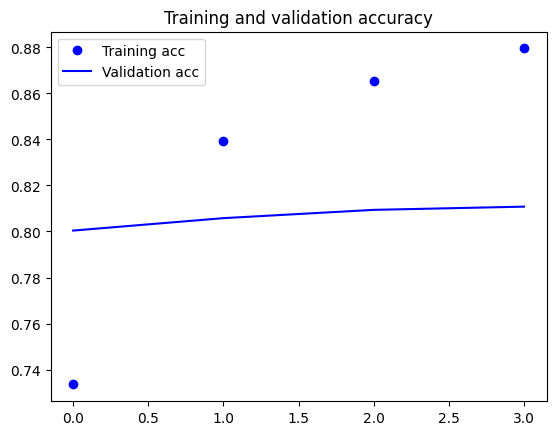

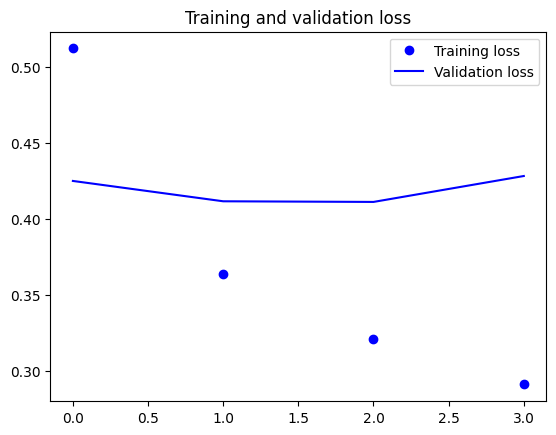

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Extract the word embedding from RNN

Finally, let's take a look at the word embedding learnt from the IMDB movie review dataset. 


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# access the embedding layer through the constructed model 
# first `0` refers to the position of embedding layer in the `model`
# `embeddings` has a shape of (num_vocab, embedding_dim) 
embeddings = model.layers[0].get_weights()[0] # layers[0]-> embedding layer

# `word_to_index` is a mapping (i.e. dict) from words to their index, e.g. `love`: 69
words_embeddings = {w:embeddings[idx] for w, idx in word_to_id.items() if idx < 10000}

# now you can use it like this for example
print(words_embeddings['great'])
print(words_embeddings['good'])
print(words_embeddings['bad'])

print("Similarity between good and great: " + str(cosine_similarity([words_embeddings['good'], words_embeddings['great']])[0,1]))
print("Similarity between good and bad: " + str(cosine_similarity([words_embeddings['good'], words_embeddings['bad']])[0,1]))

[ 0.1020254  -0.11133514 -0.06512477 -0.12132704 -0.04690856  0.04368681
  0.06251782  0.13691574  0.07643534  0.05168529  0.09342684 -0.1022673
 -0.0636091  -0.0210963   0.11093818 -0.03169762  0.07228367 -0.08800293
 -0.07582367  0.02206159 -0.13073952 -0.0780186   0.08373474  0.16270176
 -0.12088082 -0.11570656  0.08204979 -0.12617554  0.11218762  0.06968258
  0.13391922  0.09166866]
[ 0.05803274 -0.02293074 -0.04807665 -0.02436871  0.06575873  0.07976539
  0.02944523  0.04409326 -0.00736384  0.02143095  0.03686241  0.05553109
 -0.07590958  0.06959554  0.02259776  0.00106865  0.02288767 -0.06811178
  0.01470468  0.12228595 -0.01659768  0.08190075  0.03730901  0.04800043
  0.00386603 -0.03760738  0.00134684 -0.02022244 -0.01675163  0.04678787
  0.03652368  0.10710594]
[-0.15459143  0.11146055  0.11146533  0.07606027  0.11195435 -0.13356689
 -0.10400292 -0.15096994 -0.11911345 -0.0290791  -0.03935764  0.1421932
  0.09478069  0.12716979 -0.0869544   0.07390305 -0.08336964  0.11937076
 